In [1]:
# import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
# import SVM

### Prepare the data ###

Procedure: 1. normalize coding for missing values: check each feature, assign NaN to values > 95% percentile. --> 2. check each row, drop the rows where over 50% of the features are NaN. Also remove the corresponding y  --> 3. Check each columns, drop the feature where over 50% of the rows are NaN or std == 0. Record the index for test set. --> 4. Handling NaN values: check for categorical feature (record the index), assign NaN to mean for non-categorical and majority label for categorial. --> 5. One-hot encoding for categorical data. --> 6. Standardize (skip categorical 0-1 columns)  --> 7. Regard a datapoint having more than 30% of the features with Z-score>2.5 as outliers, remove from x and corresponding y. --> 8. Data Augmentation --> 9. PCA 

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./data/dataset_to_release", sub_sample=True)

In [23]:
print(x_train.shape)
print(y_train.shape)

(6563, 321)
(6563,)


In [4]:
# x_sub, y_sub = split_cross_validation(x_train, y_train, 10)
# np.shape(x_sub[0])

(32813, 321)

In [3]:
# thresholds for nans
row_nan = 0.6
feature_nan = 0.8
# threshold for categorical features
threshold_cat = 10
# threshold for outliers
z_threshold=2
feature_threshold=0.2

x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

# transform y to 0-1 encoding
y_train_processed = process_y(y_train_processed)

# Uniform missing value encoding
# x_train_processed = normalize_nan(x_train_processed)
# Remove rows with too many nans
x_train_processed, y_train_processed = drop_rows(x_train_processed, y_train_processed, row_nan) # 0.55 remains 6101 rows
# x_train_processed.shape
# Remove features with too many nans
x_train_processed, nan_indices = drop_features(x_train_processed, feature_nan) # 0.5 remains 174 features
print(x_train_processed.shape)

# get categorical feature indices
cat_indices = check_categorical(x_train_processed, threshold_cat)
# handling remaining nans
x_train_processed = fillna(x_train_processed, cat_indices)
# One hot encoding for categorical features
x_train_processed = one_hot_encoding(x_train_processed, cat_indices)
x_train_processed = standardize(x_train_processed)
x_train_processed, y_train_processed = z_outlier_removal(x_train_processed, y_train_processed, z_threshold, feature_threshold)
x_train_processed.shape
# x_train_processed = add_bias(x_train_processed)


(6368, 200)


(6098, 521)

In [6]:
np.sum(y_train_processed==1)

27108

In [7]:
print(x_train_processed.shape)
print(y_train_processed.shape)
print(np.sum(x_train_processed.std(axis=0) == 0))

(302903, 524)
(302903,)
0


In [8]:
# x_train_processed_orig = x_train.copy()
# x_train_processed_orig = fillna_with_mean(x_train_processed_orig, threshold=threshold_nan)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = polynomial_expansion_single(x_train_processed_orig, degree=2)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = add_bias(x_train_processed_orig)
# # add a column of ones
# y_train_processed_orig = y_train.copy()
# y_train_processed_orig = process_y(y_train_processed_orig)
# print(np.isnan(x_train_processed_orig).any())

In [9]:
# print(x_train_processed_orig.shape)
# print(y_train_processed_orig.shape)

In [4]:
# ## PCA feature selection 
# pre_train_data = x_train_processed.copy()

# x_pca, eig_vec, eig_val,weight = pca(pre_train_data, 200)
# print(weight)

In [11]:
# x_pca.shape

(302903, 200)

/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


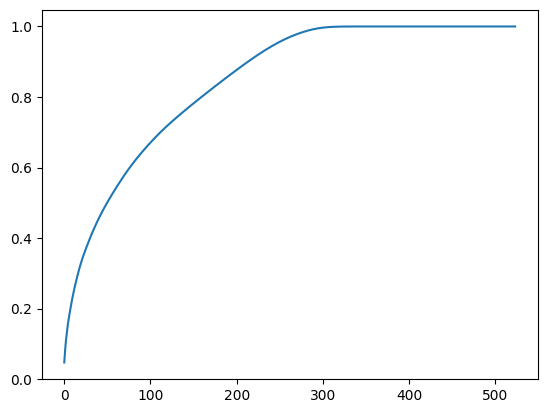

In [12]:
# cummulation = np.cumsum(weight)
## cummulation
# plt.plot(cummulation)

In [13]:
# x_pca.shape

(302903, 200)

### Experiment ###

In [14]:
# linear regression using all the features except for those having NaN values over 50% ##
sub_x, sub_y = split_cross_validation(add_bias(x_train_processed), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    # x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
    # pick one of the 10 folds as validation set
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters=200, gamma=0.01)
    y_pred = x_v @ w
    y_pred_mean = np.mean(y_pred)
    y_pred = (y_pred > y_pred_mean).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/199: loss=0.2865729328029284
GD iter. 10/199: loss=0.13946601263445396
GD iter. 20/199: loss=0.12366667198056777
GD iter. 30/199: loss=0.1144078560481228
GD iter. 40/199: loss=0.10775494697222973
GD iter. 50/199: loss=0.10258642241592701
GD iter. 60/199: loss=0.09843715485050078
GD iter. 70/199: loss=0.09505082171348743
GD iter. 80/199: loss=0.09225969624479984
GD iter. 90/199: loss=0.08994367253009612
GD iter. 100/199: loss=0.08801239776067839
GD iter. 110/199: loss=0.08639582359121509
GD iter. 120/199: loss=0.08503853588740733
GD iter. 130/199: loss=0.0838960635333123
GD iter. 140/199: loss=0.08293233693501748
GD iter. 150/199: loss=0.08211786404834029
GD iter. 160/199: loss=0.08142837904183471
GD iter. 170/199: loss=0.08084381603199367
GD iter. 180/199: loss=0.08034751445680566
GD iter. 190/199: loss=0.0799255943708258
The Accuracy is: 0.6084
The F1 score is: 0.3031
The precision is: 0.1810
The recall is: 0.9314
GD iter. 0/199: loss=0.29142764490592826
GD iter. 10/199: lo

KeyboardInterrupt: 

In [ ]:
# x_train_processed.shape

In [ ]:
# logistic regression using all the features except for those having NaN values over 50% ##
sub_x, sub_y = split_cross_validation(add_bias(x_train_processed), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=150, gamma=0.1)
    y_pred = sigmoid(x_v @ w)
    y_pred = (y_pred >= 0.7).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/149: loss=0.6810767909783251
GD iter. 1/149: loss=0.5486970120893967
GD iter. 2/149: loss=0.5308640416663686
GD iter. 3/149: loss=0.5211693036161503
GD iter. 4/149: loss=0.5141655030862539
GD iter. 5/149: loss=0.5085142799203712
GD iter. 6/149: loss=0.5037133769331086
GD iter. 7/149: loss=0.49951253656925987
GD iter. 8/149: loss=0.49576189430851453
GD iter. 9/149: loss=0.49236170193341666
GD iter. 10/149: loss=0.48924158500706244
GD iter. 11/149: loss=0.48635015562652273
GD iter. 12/149: loss=0.48364899964595187
GD iter. 13/149: loss=0.4811088622324665
GD iter. 14/149: loss=0.4787070956302764
GD iter. 15/149: loss=0.47642589678381747
GD iter. 16/149: loss=0.4742510651005098
GD iter. 17/149: loss=0.4721711133604357
GD iter. 18/149: loss=0.4701766232246444
GD iter. 19/149: loss=0.46825977266741586
GD iter. 20/149: loss=0.4664139857199197
GD iter. 21/149: loss=0.46463367016720425
GD iter. 22/149: loss=0.4629140191238966
GD iter. 23/149: loss=0.4612508594445647
GD iter. 24/149: 

In [ ]:
# logistic regression
sub_x, sub_y = split_cross_validation(add_bias(x_train_processed), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = reg_logistic_regression(y_t, x_t, lambda_=0.1, initial_w=initial_w, max_iters=500, gamma=0.15)
    y_pred = (x_v @ w >= 0.75).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/499: loss=0.7458818538124562
GD iter. 1/499: loss=0.5440900163993346
GD iter. 2/499: loss=0.5275033008894628
GD iter. 3/499: loss=0.5174744504849189
GD iter. 4/499: loss=0.5101360126567559
GD iter. 5/499: loss=0.5043193512308672
GD iter. 6/499: loss=0.49951428800683956
GD iter. 7/499: loss=0.49542793520658995
GD iter. 8/499: loss=0.49187647185804834
GD iter. 9/499: loss=0.48873909280862937
GD iter. 10/499: loss=0.4859331165027785
GD iter. 11/499: loss=0.4833997268121569
GD iter. 12/499: loss=0.48109556870031484
GD iter. 13/499: loss=0.478987652171511
GD iter. 14/499: loss=0.4770501683558637
GD iter. 15/499: loss=0.47526243907610677
GD iter. 16/499: loss=0.47360755668680443
GD iter. 17/499: loss=0.4720714559068971
GD iter. 18/499: loss=0.47064226334928727
GD iter. 19/499: loss=0.46930983024082623
GD iter. 20/499: loss=0.4680653890121086
GD iter. 21/499: loss=0.46690129562753463
GD iter. 22/499: loss=0.46581083258014827
GD iter. 23/499: loss=0.4647880556953955
GD iter. 24/499:

In [ ]:
# ridge regression using all the features except for those having NaN values over 50% ##
sub_x, sub_y = split_cross_validation(add_bias(x_train_processed), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    w, loss = ridge_regression(y_t, x_t, lambda_=0.01)
    y_pred = x_v @ w
    y_pred_mean = np.mean(y_pred)
    y_pred = (y_pred > y_pred_mean).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

The Accuracy is: 0.5911
The F1 score is: 0.2477
The precision is: 0.1449
The recall is: 0.8542
The Accuracy is: 0.5928
The F1 score is: 0.2663
The precision is: 0.1573
The recall is: 0.8654
The Accuracy is: 0.6076
The F1 score is: 0.3032
The precision is: 0.1851
The recall is: 0.8387
The Accuracy is: 0.5632
The F1 score is: 0.2400
The precision is: 0.1395
The recall is: 0.8571
The Accuracy is: 0.5780
The F1 score is: 0.2720
The precision is: 0.1611
The recall is: 0.8727
The Accuracy is: 0.5911
The F1 score is: 0.2523
The precision is: 0.1484
The recall is: 0.8400
The Accuracy is: 0.6338
The F1 score is: 0.2875
The precision is: 0.1711
The recall is: 0.9000
The Accuracy is: 0.6026
The F1 score is: 0.3046
The precision is: 0.1828
The recall is: 0.9138
The Accuracy is: 0.6125
The F1 score is: 0.2761
The precision is: 0.1636
The recall is: 0.8824
The Accuracy is: 0.6305
The F1 score is: 0.3410
The precision is: 0.2070
The recall is: 0.9672
Average accuracy score is:  0.6003212216535864
Ave

#### Hinge loss gradient descent

In [ ]:
sub_x, sub_y = split_cross_validation(add_bias(x_train_processed), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
    y_pred = ((x_v @ w) > 0.5).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/499: loss=0.9882648115725106
GD iter. 1/499: loss=0.9017428895774816
GD iter. 2/499: loss=0.8205296310724131
GD iter. 3/499: loss=0.7567389924849213
GD iter. 4/499: loss=0.7161450276239179
GD iter. 5/499: loss=0.6916835125463995
GD iter. 6/499: loss=0.674830776082536
GD iter. 7/499: loss=0.6617622683538288
GD iter. 8/499: loss=0.6511291955138866
GD iter. 9/499: loss=0.6422804981456199
GD iter. 10/499: loss=0.6357545707120806
GD iter. 11/499: loss=0.6307853555004956
GD iter. 12/499: loss=0.6265068610116423
GD iter. 13/499: loss=0.6226183312022762
GD iter. 14/499: loss=0.6191291359529025
GD iter. 15/499: loss=0.6163425963744044
GD iter. 16/499: loss=0.6137343866532734
GD iter. 17/499: loss=0.6113623006051477
GD iter. 18/499: loss=0.6091657213327429
GD iter. 19/499: loss=0.6071578584479335
GD iter. 20/499: loss=0.6052336413552044
GD iter. 21/499: loss=0.603383732134022
GD iter. 22/499: loss=0.6017281927962144
GD iter. 23/499: loss=0.6001379940498583
GD iter. 24/499: loss=0.5985

In [ ]:
# import sklearn.svm as svm
# cls = svm.SVC(C=50, kernel='rbf')
# x_t, y_t, x_v, y_v = split_data(x_train_processed_hinge, y_train_processed_hinge, 0.9)
# cls.fit(x_t, y_t)
# y_pred = cls.predict(x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

#### PCA

In [15]:
## linear regression using PCA feature selection ##
x_pca_t = add_bias(x_pca)
sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    # x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
    # x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters = 200, gamma=0.05)
    y_pred = x_v @ w
    y_pred_mean = np.mean(y_pred)
    y_pred = (y_pred >= y_pred_mean).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/199: loss=(0.27515635707163844+0j)
GD iter. 10/199: loss=(0.08984273199245048+0j)
GD iter. 20/199: loss=(0.08060750266357689+0j)
GD iter. 30/199: loss=(0.07886529366687861+0j)
GD iter. 40/199: loss=(0.07847559600273021+0j)
GD iter. 50/199: loss=(0.0783783302151632+0j)
GD iter. 60/199: loss=(0.07835091425607206+0j)
GD iter. 70/199: loss=(0.07834218765984834+0j)
GD iter. 80/199: loss=(0.07833910366872215+0j)
GD iter. 90/199: loss=(0.07833792276927705+0j)
GD iter. 100/199: loss=(0.0783374434632982+0j)
GD iter. 110/199: loss=(0.07833724047591689+0j)
GD iter. 120/199: loss=(0.0783371516904745+0j)
GD iter. 130/199: loss=(0.07833711184407235+0j)
GD iter. 140/199: loss=(0.07833709357592061+0j)
GD iter. 150/199: loss=(0.07833708504789638+0j)
GD iter. 160/199: loss=(0.07833708100472225+0j)
GD iter. 170/199: loss=(0.07833707906222277+0j)
GD iter. 180/199: loss=(0.07833707811831084+0j)
GD iter. 190/199: loss=(0.07833707765517979+0j)
The Accuracy is: 0.6069
The F1 score is: 0.2936
The pr

KeyboardInterrupt: 

In [28]:
# logistic regression using pca feature selection #
x_pca_t = add_bias(x_pca)
sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    # x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=200, gamma=0.15)
    y_pred = sigmoid(x_v @ w)
    y_pred = (y_pred >= 0.75).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/199: loss=(0.7051782385232673-0j)
GD iter. 1/199: loss=(0.5404015004541018-0j)
GD iter. 2/199: loss=(0.5237815040444291-0j)
GD iter. 3/199: loss=(0.5125213644680006-0j)
GD iter. 4/199: loss=(0.5037396832180407-0j)
GD iter. 5/199: loss=(0.4964323775304104-0j)
GD iter. 6/199: loss=(0.49014541073232765-0j)
GD iter. 7/199: loss=(0.4846201627099105-0j)
GD iter. 8/199: loss=(0.47969142164938333-0j)
GD iter. 9/199: loss=(0.4752466002781531-0j)
GD iter. 10/199: loss=(0.4712052029308098-0j)
GD iter. 11/199: loss=(0.46750730913320426-0j)
GD iter. 12/199: loss=(0.4641067384413045-0j)
GD iter. 13/199: loss=(0.4609668312389616-0j)
GD iter. 14/199: loss=(0.4580577559632113-0j)
GD iter. 15/199: loss=(0.4553547361313669-0j)
GD iter. 16/199: loss=(0.45283684730878704-0j)
GD iter. 17/199: loss=(0.45048617659717805-0j)
GD iter. 18/199: loss=(0.4482872186612688-0j)
GD iter. 19/199: loss=(0.44622643002943596-0j)
GD iter. 20/199: loss=(0.4442918919764712-0j)
GD iter. 21/199: loss=(0.4424730497523

In [58]:
x_pca_t = add_bias(x_pca)
sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(10):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
    y_pred = ((x_v @ w) > 1.5).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/499: loss=1.0386536008252525
GD iter. 1/499: loss=1.033470228437925
GD iter. 2/499: loss=1.0283024782126042
GD iter. 3/499: loss=1.0231502979043203
GD iter. 4/499: loss=1.0180136354565095
GD iter. 5/499: loss=1.0128924390003058
GD iter. 6/499: loss=1.0077866568538296
GD iter. 7/499: loss=1.002696237521482
GD iter. 8/499: loss=0.9976211296932405
GD iter. 9/499: loss=0.9925612822439578
GD iter. 10/499: loss=0.987516644232663
GD iter. 11/499: loss=0.9824871649018672
GD iter. 12/499: loss=0.9774727936768689
GD iter. 13/499: loss=0.9724734801650645
GD iter. 14/499: loss=0.9674891741552606
GD iter. 15/499: loss=0.962519825616989
GD iter. 16/499: loss=0.9575653846998238
GD iter. 17/499: loss=0.9526258017327024
GD iter. 18/499: loss=0.9477010272232479
GD iter. 19/499: loss=0.9427910118570956
GD iter. 20/499: loss=0.93789570649722
GD iter. 21/499: loss=0.9330150621832664
GD iter. 22/499: loss=0.9281490301308836
GD iter. 23/499: loss=0.9232975617310607
GD iter. 24/499: loss=0.91846060

/home/zewzhang/Course/ML/Project/ML_proj/project1/implementations.py:587: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


GD iter. 0/499: loss=1.0231306769963595
GD iter. 1/499: loss=1.017992292847826
GD iter. 2/499: loss=1.0128693795736143
GD iter. 3/499: loss=1.0077618854763268
GD iter. 4/499: loss=1.002669759044903
GD iter. 5/499: loss=0.99759294895391
GD iter. 6/499: loss=0.9925314040628456
GD iter. 7/499: loss=0.9874850734154373
GD iter. 8/499: loss=0.9824539062389468
GD iter. 9/499: loss=0.9774378519434769
GD iter. 10/499: loss=0.9724368601212814
GD iter. 11/499: loss=0.967450880546076
GD iter. 12/499: loss=0.9624798631723547
GD iter. 13/499: loss=0.9575237581347061
GD iter. 14/499: loss=0.952582515747134
GD iter. 15/499: loss=0.9476560865023801
GD iter. 16/499: loss=0.9427444210712489
GD iter. 17/499: loss=0.9378474703019366
GD iter. 18/499: loss=0.9329651852193612
GD iter. 19/499: loss=0.9280975170244955
GD iter. 20/499: loss=0.9232444170937031
GD iter. 21/499: loss=0.9184058369780769
GD iter. 22/499: loss=0.9135817284027796
GD iter. 23/499: loss=0.908772043266388
GD iter. 24/499: loss=0.903976733

In [31]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    lambda_ = trial.suggest_loguniform('lambda_', 5e-3, 5)
    thres = trial.suggest_float('thres', 0.5, 2)
    n_com = trial.suggest_int('n_com', 10, 200)
    x_pca, eig_vec, eig_val,weight = pca(pre_train_data, n_com)
    x_pca_t = add_bias(x_pca)
    sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 5)
    accs = []
    f1s = []
    # cross-validation
    for i in range(5):
        sub_cur_x = sub_x.copy()
        sub_cur_y = sub_y.copy()
        x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
        x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
        x_t, y_t = data_augmentation(x_t, y_t)
        initial_w = np.random.randn(x_t.shape[1]) * 0.01
        w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=lambda_, max_iters=250, gamma=0.01)
        y_pred = ((x_v @ w) > thres).astype(int)
        accs.append(predict_acc_pure(y_pred, y_v))
        f1s.append(predict_f1_pure(y_pred, y_v))
    print("Average accuracy score is: ", np.mean(accs))
    print("Average f1 score is: ", np.mean(f1s))
    return np.mean(f1s)

sampler = TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### Apply Kernel PCA to classification task

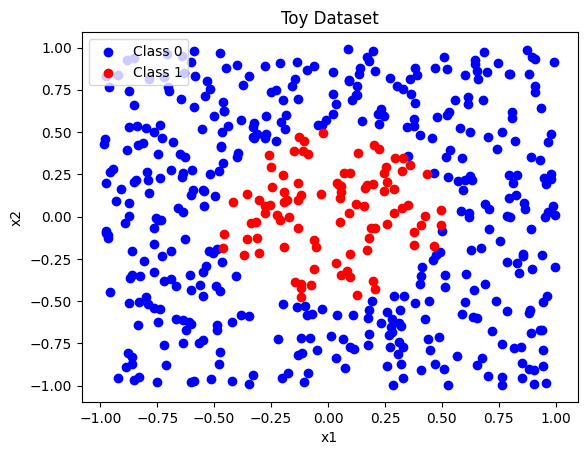

In [32]:
def generate_data(num_samples=500, radius=0.5):
    # Generate random 2D points
    x = np.random.rand(num_samples, 2) * 2 - 1 # Rescale to [-1, 1]
    
    # Create labels based on distance to the origin
    labels = (np.sum(x**2, axis=1) < radius**2).astype(int)
    
    return x, labels

x, y = generate_data()

# Visualization
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Toy Dataset')
plt.show()

In [33]:
nn = initialize_network(input_size=np.shape(x)[1], hidden_size1=10, hidden_size2=10, hidden_size3=4, output_size=1)
nn_trained = train(nn, x, y, learning_rate=0.0001, epochs=40, batch_size=200)
y_pred = predict(nn_trained,x)
predict_acc_pure(y_pred, y)
predict_f1_pure(y_pred, y)

Epoch: 0 Loss: 0.554140901035659
Epoch: 2 Loss: 0.6355115822676142
Epoch: 4 Loss: 0.5703803972660615
Epoch: 6 Loss: 0.538148358572958
Epoch: 8 Loss: 0.6037274295874099
Epoch: 10 Loss: 0.5935929089893998
Epoch: 12 Loss: 0.5377727988257001
Epoch: 14 Loss: 0.5528197762511157
Epoch: 16 Loss: 0.5266685407389036
Epoch: 18 Loss: 0.6114912648196452
Epoch: 20 Loss: 0.6243905797773407
Epoch: 22 Loss: 0.5553445897213269
Epoch: 24 Loss: 0.5752018005867288
Epoch: 26 Loss: 0.5991425648936147
Epoch: 28 Loss: 0.5570613615321734
Epoch: 30 Loss: 0.5951387318402769
Epoch: 32 Loss: 0.5971782551430359
Epoch: 34 Loss: 0.5107926032784098
Epoch: 36 Loss: 0.5418308481425692
Epoch: 38 Loss: 0.5648235199545646
The Accuracy is: 0.0020
The F1 score is: 0.0959
The precision is: 0.1346
The recall is: 0.0745


0.0958904109589041

In [36]:
import sklearn.svm as svm
from sklearn.decomposition import PCA, KernelPCA

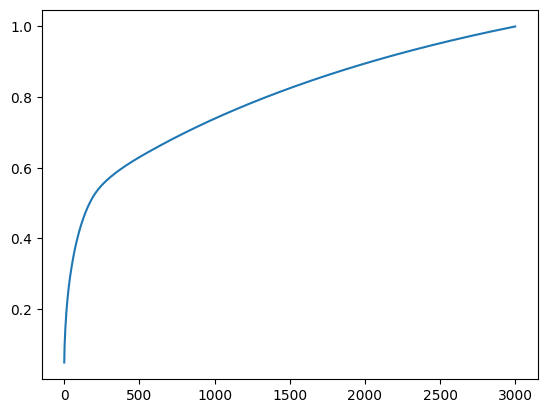

In [37]:
kernel_pca = KernelPCA(
    n_components=3000, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)
pca = PCA(n_components=None)
kernel_pca.fit(x_train_processed)
cummulation = np.cumsum(kernel_pca.eigenvalues_/np.sum(kernel_pca.eigenvalues_))
# cummulation = np.cumsum(pca.explained_variance_ratio_)
# cummulation
plt.plot(cummulation)

In [57]:
## PCA feature selection 
pre_train_data = x_train_processed.copy()
x_pca = kernel_pca.transform(pre_train_data)
# logistic regression using pca feature selection #
x_pca_t = add_bias(x_pca)
sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(1):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    # x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=3000, gamma=5)
    y_pred = sigmoid(x_v @ w)
    y_pred = (y_pred >= 0.75).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/2999: loss=0.6933423583843883
GD iter. 1/2999: loss=0.6768741700334122
GD iter. 2/2999: loss=0.6696720436679526
GD iter. 3/2999: loss=0.7761250250344813
GD iter. 4/2999: loss=1.8203439818504852
GD iter. 5/2999: loss=2.8398157584161847
GD iter. 6/2999: loss=1.964438470507169
GD iter. 7/2999: loss=2.690771834908934
GD iter. 8/2999: loss=2.0337363005400553
GD iter. 9/2999: loss=2.578452658377237
GD iter. 10/2999: loss=2.067705865665283
GD iter. 11/2999: loss=2.488087092559182
GD iter. 12/2999: loss=2.0800525770907647
GD iter. 13/2999: loss=2.412525546581288
GD iter. 14/2999: loss=2.077349955298133
GD iter. 15/2999: loss=2.3476947126344174
GD iter. 16/2999: loss=2.0632700901582224
GD iter. 17/2999: loss=2.2909998914186107
GD iter. 18/2999: loss=2.040088054497279
GD iter. 19/2999: loss=2.240604670502651
GD iter. 20/2999: loss=2.009365243412015
GD iter. 21/2999: loss=2.195048360244732
GD iter. 22/2999: loss=1.972310902411984
GD iter. 23/2999: loss=2.153028271306601
GD iter. 24/299

In [56]:
## PCA feature selection 
pre_train_data = x_train_processed.copy()
x_pca = kernel_pca.transform(pre_train_data)
# hinge regression using pca feature selection #
x_pca_t = add_bias(x_pca)
sub_x, sub_y = split_cross_validation(add_bias(x_pca_t), y_train_processed, 10)
accs = []
f1s = []
# cross-validation
for i in range(1):
    sub_cur_x = sub_x.copy()
    sub_cur_y = sub_y.copy()
    x_v, y_v = sub_cur_x.pop(i), sub_cur_y.pop(i)
    x_t, y_t = np.vstack(sub_cur_x), np.hstack(sub_cur_y)
    x_t, y_t = data_augmentation(x_t, y_t)
    initial_w = np.random.randn(x_t.shape[1]) * 0.01
    w, loss = hinge_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.1, lambda_= 1)
    y_pred = ((x_v @ w) > 0).astype(int)
    accs.append(predict_acc_pure(y_pred, y_v))
    f1s.append(predict_f1_pure(y_pred, y_v))
print("Average accuracy score is: ", np.mean(accs))
print("Average f1 score is: ", np.mean(f1s))

GD iter. 0/499: loss=1.1319681734575158
GD iter. 1/499: loss=1.035188801268022
GD iter. 2/499: loss=0.9694526428189921
GD iter. 3/499: loss=0.92434361321341
GD iter. 4/499: loss=0.8930435237072751
GD iter. 5/499: loss=0.8710672179764988
GD iter. 6/499: loss=0.855446983551322
GD iter. 7/499: loss=0.8442057145132248
GD iter. 8/499: loss=0.8360158471240554
GD iter. 9/499: loss=0.8299779678311574
GD iter. 10/499: loss=0.8254766337526389
GD iter. 11/499: loss=0.8220861068775358
GD iter. 12/499: loss=0.8195084312255893
GD iter. 13/499: loss=0.8175325280468386
GD iter. 14/499: loss=0.8160069974032347
GD iter. 15/499: loss=0.8148218957039651
GD iter. 16/499: loss=0.8138964209465421
GD iter. 17/499: loss=0.8131705093658792
GD iter. 18/499: loss=0.812599039765525
GD iter. 19/499: loss=0.8121477902703146
GD iter. 20/499: loss=0.8117905834325928
GD iter. 21/499: loss=0.8115072453278209
GD iter. 22/499: loss=0.8112821283578635
GD iter. 23/499: loss=0.8111030290307675
GD iter. 24/499: loss=0.8109603